In [1]:
import json
import numpy as np
from pathlib import Path
import pickle as pkl
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir('..')

In [106]:
with open('results_roberta.json', 'r') as f:
    obj1 = json.load(f)
    
with open('results_ernie.json', 'r') as f:
    obj2 = json.load(f)   
    
obj = obj1 | obj2
    
with open('results_misc_roberta.pkl', 'rb') as f:
    obj_misc = pkl.load(f)

In [107]:
obj.keys()

dict_keys(['liar-roberta-unmasked', 'isot-roberta-unmasked', 'coaid-roberta-unmasked', 'liar-ernie-unmasked', 'isot-ernie-unmasked', 'coaid-ernie-unmasked'])

In [108]:
obj_misc.keys()

dict_keys(['liar-roberta-unmasked', 'isot-roberta-unmasked', 'coaid-roberta-unmasked'])

In [109]:
org_scores_l = []
adv_scores_l = []
new_tokens_l = []
old_tokens_l = []
source_l = []
n_obs_l = []

for config in obj.keys():
    print(config)
    
    org_scores = np.array(obj[config]['orig_pred'])
    adv_scores = np.array(obj[config]['adv_pred'])
    replacements = obj[config]['replacements']
    
    n_obs = np.arange(len(org_scores))
    has_person_idx = np.array(list(map(lambda x: x[0] != 'NOT EXIST', replacements)))
    org_scores = org_scores[has_person_idx]
    adv_scores = adv_scores[has_person_idx]
    n_obs = n_obs[has_person_idx]
    replacements = list(filter(lambda x: x[0] != 'NOT EXIST', replacements))
    old_tokens = list(map(lambda x: x[0], replacements))
    new_tokens = list(map(lambda x: x[1], replacements))
    source = np.repeat(np.array([config]), org_scores.shape[0])
    
    org_scores_l.append(org_scores)
    adv_scores_l.append(adv_scores)
    new_tokens_l.append(new_tokens)
    old_tokens_l.append(old_tokens)
    source_l.append(source)
    n_obs_l.append(n_obs)
    
    
org_scores = np.concatenate(org_scores_l)
adv_scores = np.concatenate(adv_scores_l)
new_tokens = np.concatenate(new_tokens_l)
old_tokens = np.concatenate(old_tokens_l)
source = np.concatenate(source_l)
n_obs = np.concatenate(n_obs_l)

data = [el.split('-')[0] for el in source]
model = [el.split('-')[1] for el in source]
mode = [el.split('-')[2] for el in source]

df = pd.DataFrame({
    'org_score': org_scores,
    'adv_score': adv_scores,
    'new_token': new_tokens,
    'old_token': old_tokens,
    'data': data,
    'model': model,
    'mode': mode,
    'n_obs': n_obs
})

df['success'] = (org_scores > 0.5).astype(int) != (adv_scores > 0.5).astype(int)

liar-roberta-unmasked
isot-roberta-unmasked
coaid-roberta-unmasked
liar-ernie-unmasked
isot-ernie-unmasked
coaid-ernie-unmasked


In [110]:
dfs = []
for key, item in obj_misc.items():
    if 'ratios' in obj_misc[key].keys():
        ratios = obj_misc[key]['ratios']
        ratios = np.array(ratios)[~np.isnan(ratios)]
        df_temp = pd.DataFrame({'ratio': ratios})
        df_temp['data'] = key.split('-')[0]
        df_temp['model'] = key.split('-')[1]
        df_temp['mode'] = key.split('-')[2]
        
        dfs.append(pd.DataFrame(df_temp))
    
df_misc = pd.concat(dfs)

## Vizualizations

Text(0.5, 0.98, 'Number of successfully created counterfactuals\nusing given name or surname')

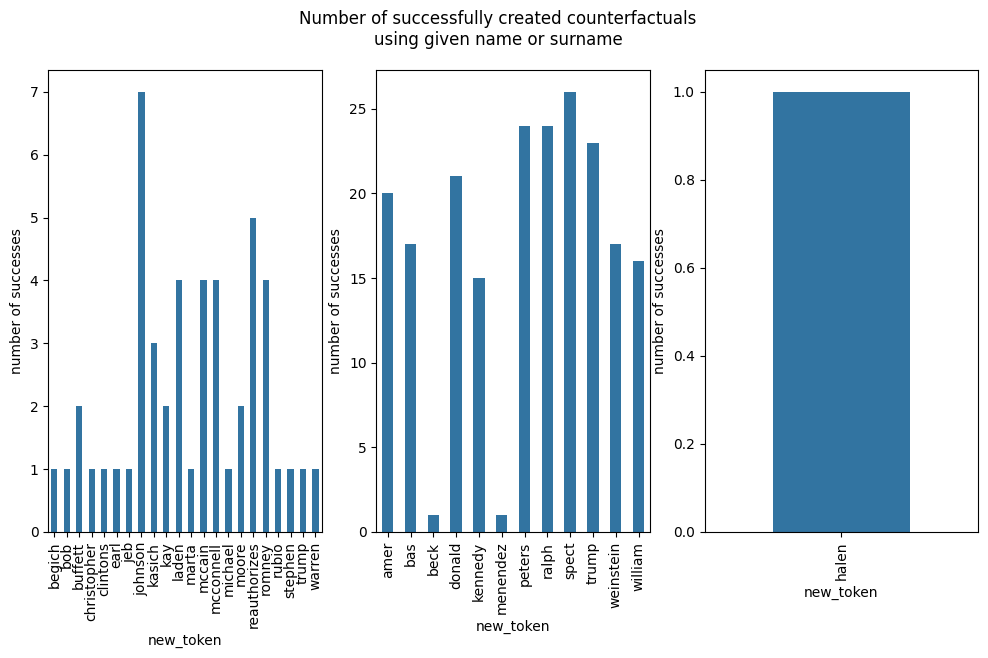

In [120]:
n = len(df['data'].unique())

fig, ax = plt.subplots(ncols=n, figsize=(12, 6))

for idx, data_name in enumerate(df['data'].unique()):
    df_temp = df[(df['data'] == data_name) & (df['success'] == True) & (df['mode'] == 'unmasked')]
    df_temp = df_temp.groupby('new_token').count().reset_index()
    
    sns.barplot(data=df_temp, x='new_token', y='success', width=0.5, ax=ax[idx])
    ax[idx].tick_params(axis='x', rotation=90)
    ax[idx].set_ylabel('number of successes')
    
plt.suptitle('Number of successfully created counterfactuals\nusing given name or surname')

Text(0.5, 1.0, 'Ratio of sucessfuly created counterfactuals')

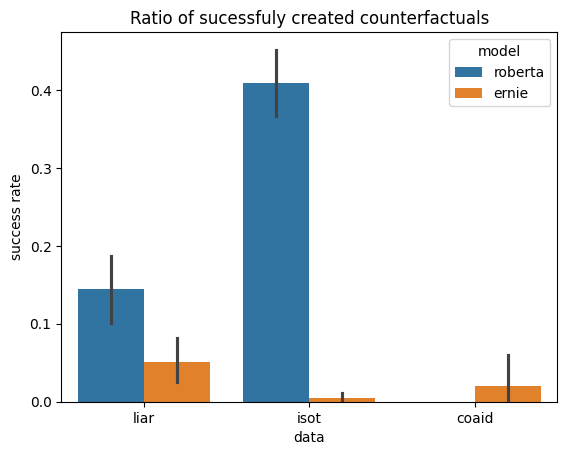

In [117]:
temp_df = df[df['mode'] == 'unmasked']
sns.barplot(data=temp_df, x='data', y='success', hue='model')
plt.ylabel('success rate')
plt.title('Ratio of sucessfuly created counterfactuals')

In [115]:
temp_df = df[df['mode'] == 'unmasked']
temp_df.groupby(['data', 'model'])['success'].mean()

data   model  
coaid  ernie      0.020000
       roberta    0.000000
isot   ernie      0.004274
       roberta    0.409274
liar   ernie      0.051282
       roberta    0.144531
Name: success, dtype: float64

Text(0.5, 1.0, 'Ratio between importance of person NE and all tokens')

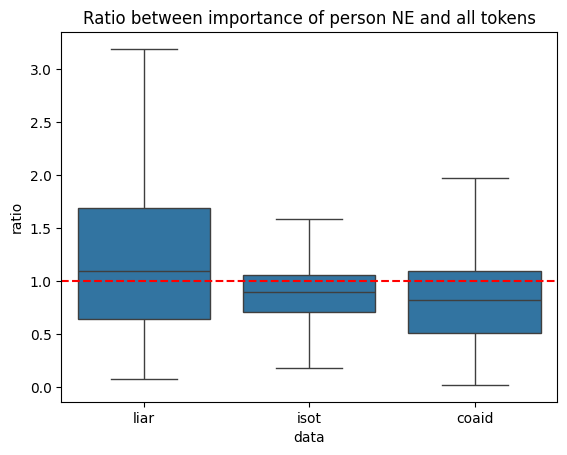

In [116]:
temp_df = df_misc[(df_misc['mode'] == 'unmasked') & (df_misc['model'] == 'roberta')]
sns.boxplot(data=temp_df, x='data', y='ratio', showfliers=False)
plt.axhline(1, c='r', linestyle='--')
plt.title('Ratio between importance of person NE and all tokens')

## ISOT issue

In [104]:
temp_df = df[df['data'] == 'isot']
(temp_df.org_score > 0.5).mean()

0.6673387096774194

In [105]:
temp_df.org_score[:10]

256    0.000347
257    0.000347
258    0.999907
259    0.999907
260    0.999907
261    0.999907
262    0.999907
263    0.999907
264    0.999907
265    0.999907
Name: org_score, dtype: float64

## Examples

In [84]:
biggest_changes_idx = np.argsort(-np.abs(org_scores - adv_scores))[:20]

In [95]:
df[df['data'] == 'liar']

,org_score,adv_score,new_token,old_token,data,model,mode,n_obs,success
0,0.570356,0.964141,obamacare,mccain,liar,roberta,unmasked,2,False
1,0.539266,0.441926,michael,scott,liar,roberta,unmasked,3,True
2,0.144300,0.174943,trump,donald,liar,roberta,unmasked,6,False
3,0.138677,0.206000,mcconnell,reagan,liar,roberta,unmasked,12,False
4,0.949407,0.967214,obamacare,crist,liar,roberta,unmasked,16,False
...,...,...,...,...,...,...,...,...,...
251,0.490660,0.727479,mcconnell,tim,liar,roberta,unmasked,785,True
252,0.232007,0.290898,rubio,rubio,liar,roberta,unmasked,786,False
253,0.182304,0.206277,johnson,chris,liar,roberta,unmasked,790,False
254,0.878919,0.950179,michael,obama,liar,roberta,unmasked,791,False


In [55]:
coaid = pd.read_csv(Path("data", 'coaid', "test.csv"), header=0)
liar = pd.read_csv(Path("data", 'liar', "test.csv"), header=0)
isot = pd.read_csv(Path("data", 'isot', "test.csv"), header=0)

In [87]:
isot.iloc[954].text

'Democrat Mayor Proclaims He’s Barring Trump From Entering St Petersburg'

In [89]:
isot.iloc[967].text

' Meet David French, The Independent Who Republicans Recruited To Run Against Donald Trump'

In [90]:
isot.iloc[210].text

' WATCH: White Trump Voter Tells Fox That President Obama Is To Blame For Racism'

In [91]:
isot.iloc[81].text

' Donald Trump Claims Paris Is In Germany, But We Assure You It Is Not'